In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from pyflann import *
import pandas as pd
import datetime

In [2]:
path1 = os.path.abspath('..')
path2 = path1.replace('\\', '/')
os.chdir(path2 + '/data/')

In [3]:
target = cv2.imread('planogram_segmented/IMG_0114_2.jpg', 1)
target_2 = cv2.imread('planogram/IMG_0115.JPG', 1)
template = cv2.imread('template/template.png', 1)

In [4]:
def get_patches_vector(image: np.ndarray, patch_size: int = 3, scale_ratio: float = 0.4) -> np.ndarray:
    print(str(datetime.datetime.now()) + ": Start calculating vector.")
    image_small_scale = cv2.resize(image, None, fx=scale_ratio, fy=scale_ratio, interpolation=cv2.INTER_CUBIC)
    image_x = image_small_scale.shape[0]
    image_y = image_small_scale.shape[1]

    padding = int(patch_size / 2)
    img = cv2.copyMakeBorder(image_small_scale, padding, padding, padding, padding
                             , cv2.BORDER_REPLICATE)
    patches_vector = np.zeros(shape=(image_x * image_y, 3 * patch_size * patch_size))
    for x in range(0, image_x):
        for y in range(0, image_y):
            patches_vector[x * image_y + y] = img[x:x + patch_size, y:y + patch_size].reshape(
                3 * patch_size * patch_size)

    print(str(datetime.datetime.now()) + ": Vector calculation done.")
    return patches_vector

In [5]:
def get_nn_pairs(template_vector: np.ndarray, target_vector: np.ndarray):
    print(str(datetime.datetime.now()) + ": Start building matching tree.")
    flann = FLANN()
    params = flann.build_index(template_vector, algorithm='kmeans', trees=1)
    print(str(datetime.datetime.now()) + ": Matching tree has been built and now start NN matching.")
    result, dists = flann.nn_index(target_vector, 1, checks=params['checks'])
    print(str(datetime.datetime.now()) + ": NN matching completed.")
    
    return result

In [6]:
template_vector = get_patches_vector(template)
target_vector = get_patches_vector(target)
target_vector_2 = get_patches_vector(target_2)
nn_matches = get_nn_pairs(template_vector, target_vector_2)

2019-04-10 22:09:00.593687: Start calculating vector.
2019-04-10 22:09:00.712386: Vector calculation done.
2019-04-10 22:09:00.712386: Start calculating vector.
2019-04-10 22:09:02.171619: Vector calculation done.
2019-04-10 22:09:02.172613: Start calculating vector.
2019-04-10 22:09:09.578016: Vector calculation done.
2019-04-10 22:09:09.581010: Start building matching tree.
2019-04-10 22:09:10.607280: Matching tree has been built and now start NN matching.
2019-04-10 22:09:40.461386: NN matching completed.


In [12]:
nn_matches.shape

(1951730,)

In [15]:
def iwu_matrix_calculator(nn_matches: np.ndarray, target: np.ndarray, scale_ratio: float=0.4):
    target_1 = cv2.resize(target, None, fx=scale_ratio, fy=scale_ratio, interpolation=cv2.INTER_CUBIC)
    nn_counts = pd.Series(nn_matches).value_counts()
    X = target_1.shape[0]
    Y = target_1.shape[1]
    
    print(str(datetime.datetime.now()) + ": Start calculating iwu score matrix.")
    nn_matrix = np.zeros(shape=(X, Y))
    for i in range(len(nn_matches)):
        nn_matrix[int(i / Y), i % Y] = nn_counts[nn_matches[i]]
    
    iwu_matrix = np.exp(-nn_matrix)
    print(str(datetime.datetime.now()) + ": Iwu score matrix calculation complete!")
    return iwu_matrix

In [17]:
iwu_matrix = iwu_matrix_calculator(nn_matches, target_2)

2019-04-10 22:31:05.317972: Start calculating iwu score matrix.
2019-04-10 22:31:34.099925: Iwu score matrix calculation complete!


In [21]:
scale_ratio = 0.4
target_1 = cv2.resize(target_2, None, fx=scale_ratio, fy=scale_ratio, interpolation=cv2.INTER_CUBIC)
template_1 = cv2.resize(template, None, fx=scale_ratio, fy=scale_ratio, interpolation=cv2.INTER_CUBIC)
X = target_1.shape[0]
Y = target_1.shape[1]
x = template_1.shape[0]
y = template_1.shape[1]
window_score_matrix = np.zeros(shape=(X - x + 1, Y - y + 1))
for m in range(window_score_matrix.shape[0]):
    for n in range(window_score_matrix.shape[1]):
        window_score_matrix[m, n] = np.sum(iwu_matrix[m:m + x, n:n + y])

In [24]:
def gray_image_show(img):
    plt.figure(figsize=(10, 12))
    plt.imshow(img, cmap='gray', interpolation='bicubic')
    plt.xticks([]), plt.yticks([])
    plt.show()

def color_image_show(img):
    plt.figure(figsize=(10, 12))
    image_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(image_show, cmap='gray', interpolation='bicubic')
    plt.xticks([]), plt.yticks([])
    plt.show()

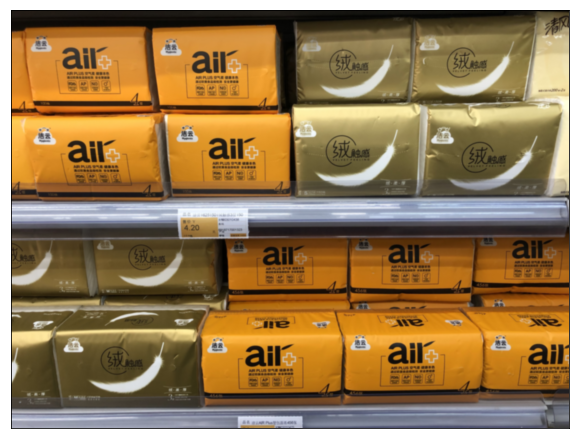

In [25]:
color_image_show(target_2)

In [26]:
import seaborn as sns

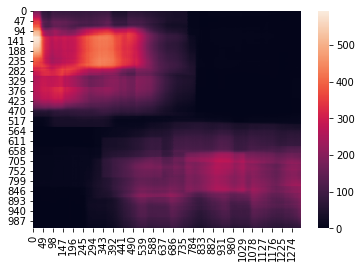

In [27]:
sns.heatmap(window_score_matrix)

In [42]:
window_score_matrix[1, 1]

168.34098219897518

In [28]:
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion

In [43]:
matrix_t = window_score_matrix.copy()

In [44]:
matrix_t[matrix_t < 200] = 0

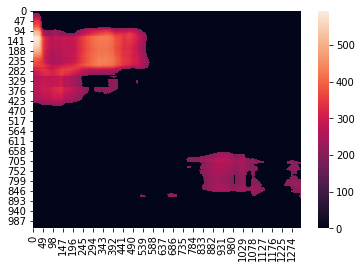

In [46]:
sns.heatmap(matrix_t)

In [52]:
neighborhood = generate_binary_structure(3, 2)

In [53]:
neighborhood

array([[[False,  True, False],
        [ True,  True,  True],
        [False,  True, False]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[False,  True, False],
        [ True,  True,  True],
        [False,  True, False]]])

In [29]:
neighborhood = generate_binary_structure(2, 2)

In [33]:
local_max = maximum_filter(window_score_matrix, footprint=neighborhood) == window_score_matrix

In [35]:
background = (window_score_matrix == 0)

In [36]:
eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)

In [37]:
detected_peaks = local_max ^ eroded_background

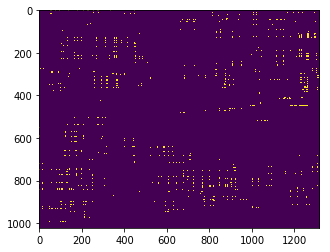

In [38]:
plt.imshow(detected_peaks)